# Zitteraal Linear Lorentz Accelerator
Notebook to visualize the created magnetic field by the Rail-Current

In [56]:
using CairoMakie     
CairoMakie.activate!()          # CairoMakie hates me
using StaticArrays, GeometryBasics, LinearAlgebra

## Physical Properties and Geometry
for future use insert the calculations of I of mathcad file

In [57]:

I_total  = 700.0            # current per rail (A)

700.0

In [58]:
# constant(s)
μ0       = 4π * 1e-7        # vacuum permeability (N A⁻²)


# Rail cross‑section (looking into the barrel)
rail_h   = 0.025             # height  (y‑direction)  = 2.5 cm
rail_len = 0.04             # length  (x‑direction)  = 4 cm
gap      = 0.01             # air gap between inner faces = 1 cm
rail_x1  = 0.0                               # inner face of left rail
rail_x2  = rail_x1 + rail_len + gap          # inner face of right rail
rail_y0, rail_y1 = 0.0, rail_h               # bottom / top of rails

# discretise each rail into Ny×Nx filaments for biot savart
Nx, Ny = 40, 25                               # along x   ×   along y (resolution) adjust if needed
xs1 = range(rail_x1 + rail_len/(2Nx), rail_x1 + rail_len - rail_len/(2Nx); length = Nx)
xs2 = xs1 .+ (rail_x2 - rail_x1)              # shift for right rail
ys  = range(rail_y0 + rail_h /(2Ny), rail_y1 - rail_h /(2Ny); length = Ny)
δI  = I_total / (Nx*Ny)                       # current per filament (A)

filaments = vcat(
    [(x, y, +1.0) for x in xs1, y in ys],    # left rail  (+z)
    [(x, y, -1.0) for x in xs2, y in ys],    # right rail 
) 

centre = Point2((rail_x1 + rail_x2)/2, rail_h/2)   # mid-gap
edge   = Point2(rail_x1 + 1e-3,       rail_h/2)    # 1 mm from left rail
far    = Point2(rail_x1 - 0.04,       rail_h/2)    # 4 cm outside

println("centre  |B| = ", norm(B(centre)), " T")   # ≈ 0.20 T
println("edge    |B| = ", norm(B(edge)),   " T")   # ≈ 0.75 T
println("outside |B| = ", norm(B(far)),    " T")   # ≈ 0.003 T



centre  |B| = 0.004812746 T
edge    |B| = 0.005048962 T
outside |B| = 0.0011035559 T


## Functions
only B for now (reminder to add Lorentz Force > Acceleration > Muzzle Velocity

In [59]:
# B‑field function 
function B(p::Point2)
    bx = 0.0;  by = 0.0
    for (x0, y0, s) in filaments
        dx = p[1] - x0
        dy = p[2] - y0
        r2 = dx^2 + dy^2 + 1e-20
        # ----- lineares (sehr langes) Leitersegment -----
        fac = s * μ0 * δI / (2π * r2)   # 1/r
        bx -= fac * dy                  #   φ-Komponente
        by += fac * dx
    end
    return Point2f(bx, by)
end
B(x::Real, y::Real) = B(Point2(x,y))  # dispatch wrapper


function in_rail(x, y)
    (rail_x1 <= x <= rail_x1 + rail_len && rail_y0 <= y <= rail_y1) ||
    (rail_x2 <= x <= rail_x2 + rail_len && rail_y0 <= y <= rail_y1)
end

in_rail (generic function with 1 method)

## Plotting and Visualization

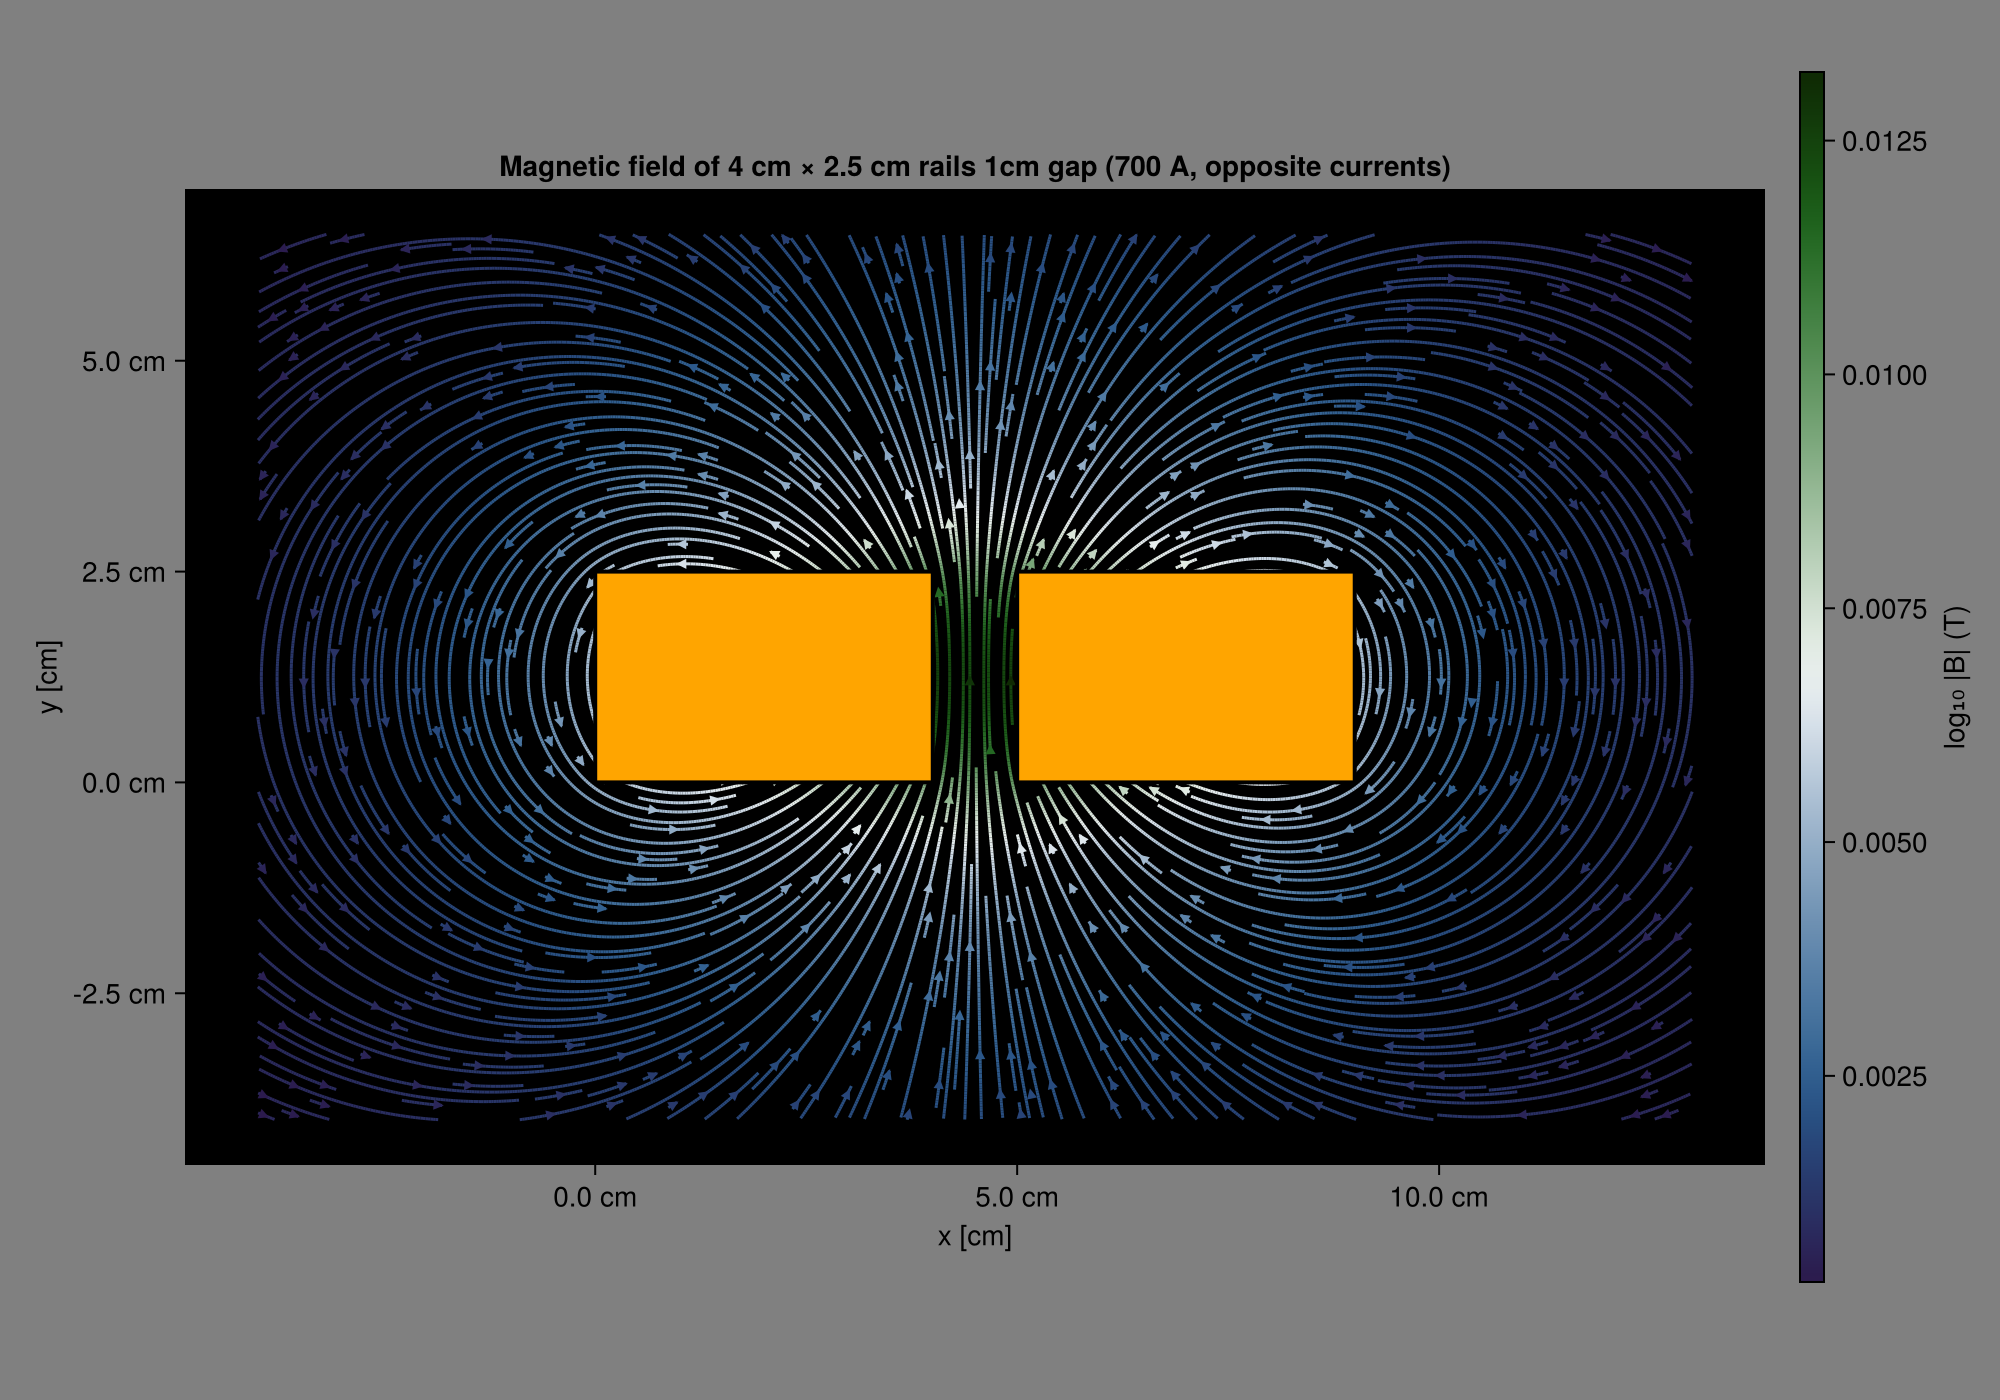

In [60]:
fig = Figure(
    backgroundcolor = :grey,
    size = (1000, 700))              # bigger canvas
cm_tick = xs -> ["$(round(100x; digits = 1)) cm" for x in xs]

ax = Axis(fig[1, 1];
          backgroundcolor = :black,
          aspect = DataAspect(),
          title  = "Magnetic field of 4 cm × 2.5 cm rails 1cm gap (700 A, opposite currents)",
          xlabel = "x [cm]", ylabel = "y [cm]",
          xtickformat = cm_tick, ytickformat = cm_tick,
          xminorticksvisible = false, yminorticksvisible = false)

# expand view window to show more field
pad = 0.04
xspan = (rail_x1 - pad) .. (rail_x2 + rail_len + pad)
yspan = (rail_y0 - pad) .. (rail_y1 + pad)

# darkred (strong) → orange → yellow (weak)
field_cmap = cgrad(:cork)


# function rediefine cuz gpt said so
f(x,y) = B(Point2(x,y)) 
#  streamlines coloured 
sp = streamplot!(ax, B, xspan, yspan;
                 linewidth  = 1.5,
                 color      = norm, 
                 colormap   = field_cmap,                       
                 gridsize   = (140, 90),
                 density    = 0.8,
                 stepsize   = 0.0003,
                 maxsteps   = 18_000,
                 arrow_size = 7)

# 2colour bar to decode intensity
Colorbar(fig[1, 2], sp, label = "B (T)")


# draw orange rails
poly!(ax, [rail_x1, rail_x1+rail_len, rail_x1+rail_len, rail_x1],
          [rail_y0, rail_y0,          rail_y1,          rail_y1];
      strokewidth = 2, color = :orange, transparency = true)
poly!(ax, [rail_x2, rail_x2+rail_len, rail_x2+rail_len, rail_x2],
          [rail_y0, rail_y0,          rail_y1,          rail_y1];
      strokewidth = 2, color = :orange, transparency = true)

fig # display